In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
import glob
import json
import pandas as pd
from tqdm import tqdm

files = glob.glob('Data/train-clean-100/*/*/*.trans.txt')
df = []
for file_path in tqdm(files):
    file = open(file_path).read().split('\n')
    file_path = '\\'.join(file_path.split('\\')[:-1])
    for i in range(len(file)):
        a = file[i].split()
        if len(a) > 2:
            filename = file_path+'\\'+a[0]+'.flac'
            df.append([filename, ' '.join(a[1:])])
df = pd.DataFrame(df, columns = ['path', 'label'])
df.head()

100%|████████████████████████████████████████████████████████████████████████████████| 585/585 [00:13<00:00, 43.20it/s]


,path,label
0,Data/train-clean-100\103\1240\103-1240-0000.flac,CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED M...
1,Data/train-clean-100\103\1240\103-1240-0001.flac,THAT HAD ITS SOURCE AWAY BACK IN THE WOODS OF ...
2,Data/train-clean-100\103\1240\103-1240-0002.flac,FOR NOT EVEN A BROOK COULD RUN PAST MISSUS RAC...
3,Data/train-clean-100\103\1240\103-1240-0003.flac,AND THAT IF SHE NOTICED ANYTHING ODD OR OUT OF...
4,Data/train-clean-100\103\1240\103-1240-0004.flac,BUT MISSUS RACHEL LYNDE WAS ONE OF THOSE CAPAB...


# EDA

In [2]:
print('Number of audio files: {}'.format(df.shape[0]) )

Number of audio files: 28539


In [3]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.1, random_state = 0)
train, val = train_test_split(train, test_size = 0.1, random_state = 0)

In [16]:
length = []
for label in train.label.values:
    length.append(len(label))

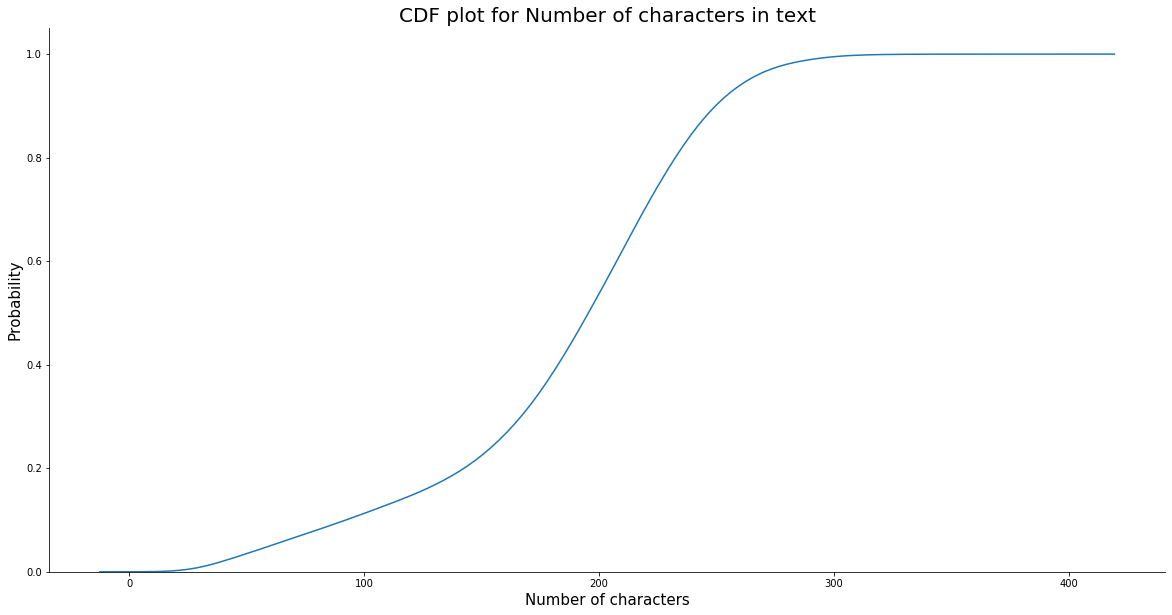

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (20, 10))
ax = sns.kdeplot(length, cumulative = True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('CDF plot for Number of characters in text', fontdict = {'fontsize': 20})
plt.xlabel('Number of characters', fontdict = {'fontsize': 15})
plt.ylabel('Probability', fontdict = {'fontsize': 15})
plt.show()

In [19]:
import numpy as np
for i in range(0, 101, 10):
    print(i, 'th percentile is' ,np.percentile(length, i))
for i in range(90, 101, 1):
    print(i, 'th percentile is' ,np.percentile(length, i))
for i in [99.0, 99.1, 99.2, 99.3, 99.4, 99.5, 99.6, 99.7, 99.8, 99.9, 100]:
    print(i, 'th percentile is' ,np.percentile(length, i))

0 th percentile is 9.0
10 th percentile is 93.0
20 th percentile is 143.0
30 th percentile is 167.5
40 th percentile is 183.0
50 th percentile is 196.0
60 th percentile is 208.0
70 th percentile is 219.0
80 th percentile is 232.0
90 th percentile is 249.0
100 th percentile is 398.0
90 th percentile is 249.0
91 th percentile is 251.0
92 th percentile is 253.0
93 th percentile is 256.0
94 th percentile is 259.0
95 th percentile is 262.25
96 th percentile is 266.0
97 th percentile is 271.0
98 th percentile is 279.0
99 th percentile is 290.0
100 th percentile is 398.0
99.0 th percentile is 290.0
99.1 th percentile is 291.0
99.2 th percentile is 292.0799999999981
99.3 th percentile is 294.0
99.4 th percentile is 296.0
99.5 th percentile is 298.0
99.6 th percentile is 301.0
99.7 th percentile is 304.0
99.8 th percentile is 308.77000000000044
99.9 th percentile is 315.0
100 th percentile is 398.0


> <strong> Aim </strong> :Plot for determining the distribution of Number of words in text.

> <strong>Conclusion : </strong> 99.9% of texts has word count less than 315.

In [4]:
import soundfile
from numpy.lib.stride_tricks import as_strided

def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)
    
    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])
    return x, freqs

def spectrogram_from_file(filename):
    step=10
    window=20
    max_freq=None
    eps=1e-14
    with soundfile.SoundFile(filename) as sound_file:
        audio = sound_file.read(dtype='float32')
        sample_rate = sound_file.samplerate
        if audio.ndim >= 2:
            audio = np.mean(audio, 1)
        if max_freq is None:
            max_freq = sample_rate / 2
        
        hop_length = int(0.001 * step * sample_rate)
        fft_length = int(0.001 * window * sample_rate)
        pxx, freqs = spectrogram(
            audio, fft_length=fft_length, sample_rate=sample_rate,
            hop_length=hop_length)
        ind = np.where(freqs <= max_freq)[0][-1] + 1
    return np.transpose(np.log(pxx[:ind, :] + eps))

In [9]:
audio_length = []
for i in tqdm(train.path.values):
    audio_length.append(spectrogram_from_file(i).shape[0])

100%|████████████████████████████████████████████████████████████████████████████| 23116/23116 [41:49<00:00,  9.21it/s]


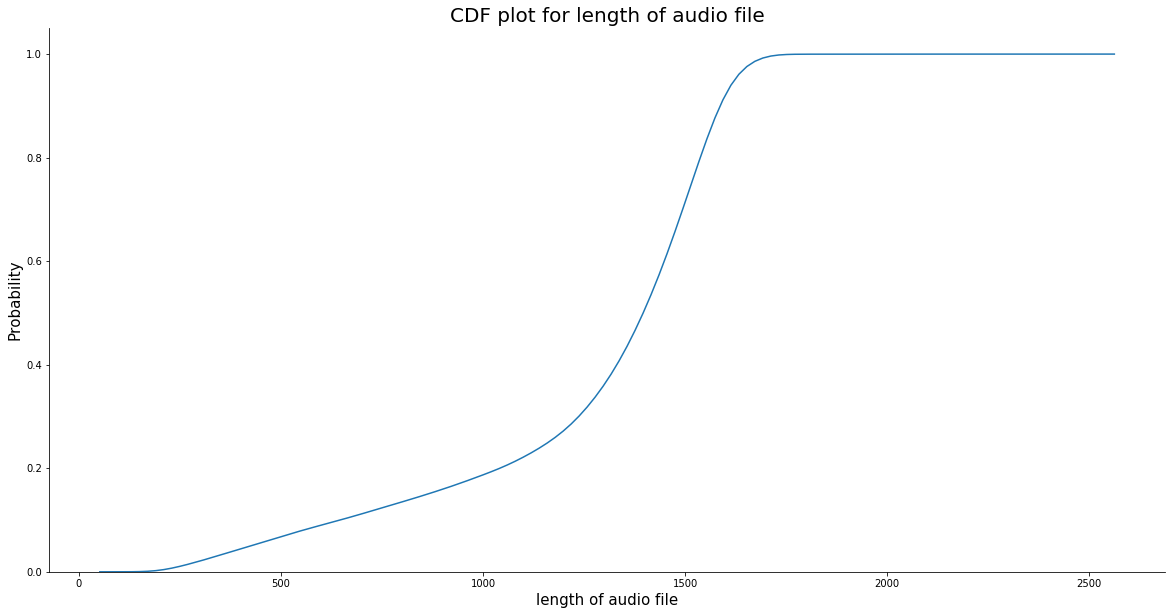

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (20, 10))
ax = sns.kdeplot(audio_length, cumulative = True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('CDF plot for length of audio file', fontdict = {'fontsize': 20})
plt.xlabel('length of audio file', fontdict = {'fontsize': 15})
plt.ylabel('Probability', fontdict = {'fontsize': 15})
plt.show()

In [12]:
import numpy as np
for i in range(0, 101, 10):
    print(i, 'th percentile is' ,np.percentile(audio_length, i))
for i in range(90, 101, 1):
    print(i, 'th percentile is' ,np.percentile(audio_length, i))
for i in [99.0, 99.1, 99.2, 99.3, 99.4, 99.5, 99.6, 99.7, 99.8, 99.9, 100]:
    print(i, 'th percentile is' ,np.percentile(audio_length, i))

0 th percentile is 163.0
10 th percentile is 646.0
20 th percentile is 1044.0
30 th percentile is 1241.0
40 th percentile is 1335.0
50 th percentile is 1399.0
60 th percentile is 1451.0
70 th percentile is 1495.0
80 th percentile is 1536.0
90 th percentile is 1580.0
100 th percentile is 2451.0
90 th percentile is 1580.0
91 th percentile is 1585.0
92 th percentile is 1590.0
93 th percentile is 1595.0
94 th percentile is 1601.0
95 th percentile is 1608.0
96 th percentile is 1618.0
97 th percentile is 1630.0
98 th percentile is 1645.0
99 th percentile is 1669.8499999999985
100 th percentile is 2451.0
99.0 th percentile is 1669.8499999999985
99.1 th percentile is 1672.0
99.2 th percentile is 1674.0
99.3 th percentile is 1676.0
99.4 th percentile is 1678.3100000000013
99.5 th percentile is 1681.4249999999993
99.6 th percentile is 1686.5400000000009
99.7 th percentile is 1692.0
99.8 th percentile is 1696.0
99.9 th percentile is 1709.0
100 th percentile is 2451.0


> <strong> Aim </strong> :Plot for determining the distribution of length of audio files.

> <strong>Conclusion : </strong> 99.9% of audio files has length less than 1709.

# Modeling

In [5]:
vocab = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', \
         'u', 'v', 'w', 'x', 'y', 'z', ' ', '<SOT>', '<EOT>']
char_index = {char: index+1 for index, char in enumerate(vocab)}
index_char = {index+1: char for index, char in enumerate(vocab)}

In [6]:
char_maxlen = 315
audio_maxlen = 1709
batch_size = 8
num_classes = len(vocab)+1
lstm_size = 64

In [13]:
import numpy as np
import math
import re
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

class BatchGenerator(Sequence):
    def __init__(self, train_file, batch_size, num_classes, char_maxlen, audio_maxlen, shuffle = True):
        self.paths = train_file.path.values
        self.labels = train_file.label.values
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.char_maxlen = char_maxlen
        self.audio_maxlen = audio_maxlen
        self.shuffle = shuffle      
        
        if self.shuffle :
            np.random.shuffle([self.paths, self.labels])
    
    def __len__(self):
        return math.ceil(len(self.paths) / self.batch_size)

    def on_epoch_end(self):
        if self.shuffle :
            np.random.shuffle([self.paths, self.labels])

    def preprocess_label(self, text):
        label = []
        text = text.lower()
        text = re.sub('[^A-Za-z0-9 ]+', '', text)
        label.append(char_index['<SOT>'])
        for char in text:
            label.append(char_index[char])
        label.append(char_index['<EOT>'])
        inp = pad_sequences([label[:-1]], maxlen = char_maxlen+2, padding = 'post')[0]
        out = pad_sequences([label[1:]], maxlen = char_maxlen+2, padding = 'post')[0]
        return inp, out

    def __getitem__(self, idx):     
        l_bound = idx*self.batch_size
        r_bound = (idx+1)*self.batch_size
        
        if r_bound > len(self.paths):
            r_bound = len(self.paths)
            l_bound = r_bound - len(self.paths)
        
        enc_inp = []
        dec_inp = []
        y = np.zeros((self.batch_size, self.char_maxlen+2))
        for ind, i in enumerate(range(l_bound, r_bound)):   
            if ind >= self.batch_size or ind < 0:
                continue
  
            x_data = spectrogram_from_file(self.paths[i])
            x_data = pad_sequences([x_data], maxlen = self.audio_maxlen, padding = 'post', dtype = np.float32)[0]
            inp, out = self.preprocess_label(self.labels[i])
            enc_inp.append(x_data)
            dec_inp.append(inp)
            y[ind] = out
        return tuple([[tf.convert_to_tensor(enc_inp), tf.convert_to_tensor(dec_inp)], tf.convert_to_tensor(y)])

In [14]:
train_datagen = BatchGenerator(train, batch_size, num_classes, char_maxlen, audio_maxlen)
val_datagen  = BatchGenerator(val, batch_size, num_classes, char_maxlen, audio_maxlen)
test_datagen = BatchGenerator(test, batch_size, num_classes, char_maxlen, audio_maxlen)

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import to_categorical

class Model(tf.keras.Model):
    def __init__(self, char_maxlen, audio_maxlen, lstm_size, num_classes, embedding_size):
        super().__init__()
        self.num_classes = num_classes
        self.char_maxlen = char_maxlen
        self.audio_maxlen = audio_maxlen
        self.batch_size = batch_size
        self.lstm_size = lstm_size
        self.enc_lstm = LSTM(units=lstm_size, return_sequences=True, return_state = True, recurrent_dropout=0.0)
        self.char_embed = Embedding(input_dim = num_classes, output_dim = embedding_size, input_length = char_maxlen)
        self.dec_lstm = LSTM(units= lstm_size, return_sequences=True, return_state = True, recurrent_dropout=0.0)
        self.fc = Dense(num_classes, activation='softmax')

    def call(self, x):
        return self.model(x)
    
    def initialize_states(self):
        return [tf.zeros((self.batch_size, self.lstm_size)), tf.zeros((self.batch_size, self.lstm_size))]
 
    def model(self, x):
        enc_inp, dec_inp = x[0], x[1]
        output_state, enc_h, enc_c = self.enc_lstm(enc_inp, initial_state = self.initialize_states())
        char_embed = self.char_embed(dec_inp)
        output_state, _, _ = self.dec_lstm(char_embed, initial_state = [enc_h, enc_c])
        return self.fc(output_state)

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import to_categorical

class PredModel(tf.keras.Model):
    def __init__(self, char_maxlen, audio_maxlen, lstm_size, num_classes, embedding_size, batch_size):
        super().__init__()
        self.num_classes = num_classes
        self.char_maxlen = char_maxlen
        self.audio_maxlen = audio_maxlen
        self.batch_size = batch_size
        self.lstm_size = lstm_size
        self.enc_lstm = LSTM(units=lstm_size, return_sequences=True, return_state = True, recurrent_dropout=0.0)
        self.char_embed = Embedding(input_dim = num_classes, output_dim = embedding_size, input_length = char_maxlen)
        self.dec_lstm = LSTM(units= lstm_size, return_sequences=True, return_state = True, recurrent_dropout=0.0)
        self.fc = Dense(num_classes, activation='softmax')

    def call(self, x):
#         print(x)
        return self.model(x)
    
    def initialize_states(self):
        return [tf.zeros((self.batch_size, self.lstm_size)), tf.zeros((self.batch_size, self.lstm_size))]
 
    def model(self, x):
        enc_inp= x
        output_state, enc_h, enc_c = self.enc_lstm(enc_inp, initial_state = self.initialize_states())
        pred = tf.expand_dims([char_index['<SOT>']], 0)
        dec_h = enc_h
        dec_c = enc_c
        all_pred = []
#         print(enc_h, enc_c)
        for t in range(self.char_maxlen): 
            pred = self.char_embed(pred)
            pred, dec_h, dec_c = self.dec_lstm(pred, [dec_h, dec_c])
            pred = self.fc(pred)
            pred = tf.argmax(pred, axis = -1)
#             print(pred)
            all_pred.append(pred)
        return all_pred

In [15]:
model = Model(char_maxlen, audio_maxlen, lstm_size, num_classes, 100)
model.compile(optimizer="adam", loss= 'sparse_categorical_crossentropy')

callbacks = [ModelCheckpoint('tts_BiLSTM_segmented_{}.h5'.format(lstm_size), save_best_only= True, verbose = 1),
             EarlyStopping(patience = 5, verbose = 1),
             ReduceLROnPlateau(patience = 3, verbose = 1)]

model.fit(x = train_datagen, 
          steps_per_epoch = train.shape[0]//batch_size,
          validation_data = val_datagen,
          validation_steps = val.shape[0]//batch_size,
          epochs = 5,  
          callbacks = callbacks,
          verbose = 1)

Epoch 1/5
2889/2889 [==============================] - ETA: 0s - loss: 1.2191
Epoch 00001: val_loss improved from inf to 1.03576, saving model to tts_BiLSTM_segmented_64.h5
2889/2889 [==============================] - 1944s 673ms/step - loss: 1.2191 - val_loss: 1.0358
Epoch 2/5
2889/2889 [==============================] - ETA: 0s - loss: 1.0120
Epoch 00002: val_loss improved from 1.03576 to 0.96782, saving model to tts_BiLSTM_segmented_64.h5
2889/2889 [==============================] - 1101s 381ms/step - loss: 1.0120 - val_loss: 0.9678
Epoch 3/5
2889/2889 [==============================] - ETA: 0s - loss: 0.9648
Epoch 00003: val_loss improved from 0.96782 to 0.93758, saving model to tts_BiLSTM_segmented_64.h5
2889/2889 [==============================] - 1105s 383ms/step - loss: 0.9648 - val_loss: 0.9376
Epoch 4/5
2889/2889 [==============================] - ETA: 0s - loss: 0.9407
Epoch 00004: val_loss improved from 0.93758 to 0.91895, saving model to tts_BiLSTM_segmented_64.h5
2889/288

In [ ]:
model.compile(optimizer="adam", loss= 'sparse_categorical_crossentropy', metrics = ['acc'])
model.fit(x = train_datagen, 
          steps_per_epoch = train.shape[0]//batch_size,
          validation_data = val_datagen,
          validation_steps = val.shape[0]//batch_size,
          epochs = 20,  
          callbacks = callbacks,
          verbose = 1)

Epoch 1/20
2889/2889 [==============================] - ETA: 0s - loss: 0.9136 - acc: 0.7179
Epoch 00001: val_loss improved from 0.90645 to 0.89667, saving model to tts_BiLSTM_segmented_64.h5
2889/2889 [==============================] - 1910s 661ms/step - loss: 0.9136 - acc: 0.7179 - val_loss: 0.8967 - val_acc: 0.7235
Epoch 2/20
 514/2889 [====>.........................] - ETA: 37:54 - loss: 0.9103 - acc: 0.7189

In [23]:
model.compile(optimizer="adam", loss= 'sparse_categorical_crossentropy', metrics = ['acc'])
model.evaluate(test_datagen)

266/357 [=====================>........] - ETA: 2:24 - loss: 0.9200 - acc: 0.7156

KeyboardInterrupt: 

In [19]:
pred_model = PredModel(char_maxlen, audio_maxlen, lstm_size, num_classes, 100, batch_size = 1)
pred_model.compile(optimizer="adam", loss= 'sparse_categorical_crossentropy')
pred_model.build(input_shape = (1, audio_maxlen, 161))
pred_model.load_weights('tts_BiLSTM_segmented_{}.h5'.format(lstm_size))

In [21]:
def predict(audio_path):
    x_data = spectrogram_from_file(audio_path)
    x_data = pad_sequences([x_data], maxlen = audio_maxlen, padding = 'post', dtype = np.float32)
    pred = pred_model.predict(x_data)
    sentence = []
    for i in pred:
        if index_char[i[0][0]] == '<EOT>':
            break
        sentence.append(index_char[i[0][0]])
    return ''.join(sentence)

In [22]:
predict(test.path.values[0])

[[[-18.15438  -16.614845 -18.18763  ... -25.785963 -25.439518 -25.888025]
  [-18.097923 -16.801096 -17.173708 ... -25.674158 -26.196941 -27.523098]
  [-22.728374 -16.903528 -16.958282 ... -26.339533 -25.872852 -27.111591]
  ...
  [  0.         0.         0.       ...   0.         0.         0.      ]
  [  0.         0.         0.       ...   0.         0.         0.      ]
  [  0.         0.         0.       ...   0.         0.         0.      ]]]
[array([[1]], dtype=int64), array([[14]], dtype=int64), array([[4]], dtype=int64), array([[27]], dtype=int64), array([[20]], dtype=int64), array([[8]], dtype=int64), array([[5]], dtype=int64), array([[27]], dtype=int64), array([[19]], dtype=int64), array([[20]], dtype=int64), array([[18]], dtype=int64), array([[5]], dtype=int64), array([[1]], dtype=int64), array([[19]], dtype=int64), array([[5]], dtype=int64), array([[4]], dtype=int64), array([[27]], dtype=int64), array([[20]], dtype=int64), array([[8]], dtype=int64), array([[5]], dtype=int64

'and the streased the streased the streased the streased the streased the streased the streased the streased the streased the streased the streased the streased the streased the streased the streased the streased the streased the streased the streased the streased the streased the streased the streased the streased'